In [7]:
from pandas import DataFrame, read_csv, set_option, cut, qcut
from matplotlib.pyplot import figure, show, subplots, savefig
from ds_charts import dummify, plot_line, multiple_line_chart
from  mlxtend.frequent_patterns import apriori, association_rules
set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

sample = 0.001

file_tag = 'set2'
filename = 'lab03_knn_and_scaling/ew_data/set2'
target = 'ALARM'

dataOriginal: DataFrame = read_csv(f'ew_data/{file_tag}_mv_dummified.csv')
dataOriginal = dataOriginal.sample(frac=sample, replace=True, random_state=1)

## After equal-frequency

In [8]:
data_treatment = 'equal_frequency' 
data = dataOriginal.drop(['GbCity', 'GbProv','Field_1'], axis=1)
columns = ['CO_Mean','CO_Min', 'CO_Max', 'CO_Std', 'NO2_Mean', 'NO2_Min', 'NO2_Max', 'NO2_Std', 'O3_Mean', 'O3_Min', 'O3_Max','O3_Std', 'PM2.5_Mean', 'PM2.5_Min','PM2.5_Max','PM2.5_Std','PM10_Mean','PM10_Min','PM10_Max','PM10_Std','SO2_Mean','SO2_Min','SO2_Max','SO2_Std','hour','day','year']
data = data[columns]
bins = 3
for col in columns:
    data[col] = qcut(data[col], bins, duplicates='drop')
data = dummify(data, columns)
for col in data.columns:
    if col not in columns:
        data[col] = data[col].fillna(False)
        data[col] = data[col].astype(int)

data

,"CO_Mean_(0.329, 0.771]","CO_Mean_(0.771, 0.918]","CO_Mean_(0.918, 1.171]","CO_Min_(0.249, 0.463]","CO_Min_(0.463, 0.67]","CO_Min_(0.67, 0.8]","CO_Max_(0.399, 0.967]","CO_Max_(0.967, 1.363]","CO_Max_(1.363, 1.83]","CO_Std_(0.034, 0.126]","CO_Std_(0.126, 0.207]","CO_Std_(0.207, 0.396]","NO2_Mean_(13.869, 20.192]","NO2_Mean_(20.192, 37.111]","NO2_Mean_(37.111, 53.042]","NO2_Min_(7.999, 10.0]","NO2_Min_(10.0, 20.0]","NO2_Min_(20.0, 36.0]","NO2_Max_(22.999, 33.0]","NO2_Max_(33.0, 59.0]","NO2_Max_(59.0, 73.0]","NO2_Std_(3.674, 5.296]","NO2_Std_(5.296, 10.616]","NO2_Std_(10.616, 16.537]","O3_Mean_(15.374, 30.0]","O3_Mean_(30.0, 89.198]","O3_Mean_(89.198, 132.125]","O3_Min_(2.999, 8.0]","O3_Min_(8.0, 32.0]","O3_Min_(32.0, 89.0]","O3_Max_(33.999, 71.667]","O3_Max_(71.667, 127.0]","O3_Max_(127.0, 207.0]","O3_Std_(7.449999999999999, 20.775]","O3_Std_(20.775, 29.122]","O3_Std_(29.122, 44.295]","PM2.5_Mean_(10.772, 28.973]","PM2.5_Mean_(28.973, 52.667]","PM2.5_Mean_(52.667, 67.958]","PM2.5_Min_(4.999, 20.0]","PM2.5_Min_(20.0, 30.0]","PM2.5_Min_(30.0, 46.0]","PM2.5_Max_(19.999, 46.0]","PM2.5_Max_(46.0, 70.333]","PM2.5_Max_(70.333, 115.0]","PM2.5_Std_(3.4370000000000003, 7.023]","PM2.5_Std_(7.023, 11.43]","PM2.5_Std_(11.43, 27.756]","PM10_Mean_(31.317, 51.875]","PM10_Mean_(51.875, 89.181]","PM10_Mean_(89.181, 121.208]","PM10_Min_(7.999, 33.0]","PM10_Min_(33.0, 54.0]","PM10_Min_(54.0, 80.0]","PM10_Max_(58.999, 80.667]","PM10_Max_(80.667, 118.667]","PM10_Max_(118.667, 190.0]","PM10_Std_(6.31, 13.726]","PM10_Std_(13.726, 21.177]","PM10_Std_(21.177, 41.835]","SO2_Mean_(3.6950000000000003, 8.431]","SO2_Mean_(8.431, 12.278]","SO2_Mean_(12.278, 27.208]","SO2_Min_(1.999, 6.0]","SO2_Min_(6.0, 8.0]","SO2_Min_(8.0, 16.0]","SO2_Max_(5.999, 13.333]","SO2_Max_(13.333, 21.667]","SO2_Max_(21.667, 65.0]","SO2_Std_(0.524, 1.74]","SO2_Std_(1.74, 4.242]","SO2_Std_(4.242, 13.273]","hour_(0.999, 3.333]","hour_(3.333, 7.667]","hour_(7.667, 12.0]","day_(2.999, 3.667]","day_(3.667, 10.333]","day_(10.333, 29.0]","year_(2019.999, 2021.0]"
128037,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,1
5192,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,1
50057,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,1
109259,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1
73349,0,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,1
117583,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,1
21440,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1
138823,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,1
31228,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1
21758,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,0,1,0,0,1


In [9]:
MIN_SUP: float = 0.001
var_min_sup =[0.2, 0.1] + [i*MIN_SUP for i  in range(100, 0, -10)]

patterns: DataFrame = apriori(data, min_support=MIN_SUP, use_colnames=True, verbose=True)
print(len(patterns),'patterns')
nr_patterns = []
for sup in var_min_sup:
    pat = patterns[patterns['support'] >= sup]
    nr_patterns.append(len(pat))

figure(figsize=(6, 4))
plot_line(var_min_sup, nr_patterns, title='Nr Patterns x Support', xlabel='support', ylabel='Nr Patterns')
savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_patterns_support.png')
show()

Processing 69988572 combinations | Sampling itemset size 6

In [1]:
MIN_CONF: float = 0.1
rules = association_rules(patterns, metric='confidence', min_threshold=MIN_CONF*5, support_only=False)
print(f'\tfound {len(rules)} rules')

NameError: name 'association_rules' is not defined

In [ ]:
def plot_top_rules(rules: DataFrame, metric: str, per_metric: str, file_tag: str, data_treatment: str) -> None:
    _, ax = subplots(figsize=(6, 3))
    ax.grid(False)
    ax.set_axis_off()
    ax.set_title(f'TOP 10 per Min {per_metric} - {metric}', fontweight="bold")
    text = ''
    cols = ['antecedents', 'consequents']
    rules[cols] = rules[cols].applymap(lambda x: tuple(x))
    for i in range(len(rules)):
        rule = rules.iloc[i]
        text += f"{rule['antecedents']} ==> {rule['consequents']}"
        text += f"(s: {rule['support']:.2f}, c: {rule['confidence']:.2f}, lift: {rule['lift']:.2f})\n"
    ax.text(0, 0, text)
    savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_top_{metric}_{per_metric}.png')
    show()

def analyse_per_metric(rules: DataFrame, metric: str, metric_values: list, file_tag: str, data_treatment: str) -> list:
    print(f'Analyse per {metric}...')
    conf = {'avg': [], 'top25%': [], 'top10': []}
    lift = {'avg': [], 'top25%': [], 'top10': []}
    top_conf = []
    top_lift = []
    nr_rules = []
    for m in metric_values:
        rs = rules[rules[metric] >= m]
        nr_rules.append(len(rs))
        conf['avg'].append(rs['confidence'].mean(axis=0))
        lift['avg'].append(rs['lift'].mean(axis=0))

        top_conf = rs.nlargest(int(0.25*len(rs)), 'confidence')
        conf['top25%'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(int(0.25*len(rs)), 'lift')
        lift['top25%'].append(top_lift['lift'].mean(axis=0))

        top_conf = rs.nlargest(10, 'confidence')
        conf['top10'].append(top_conf['confidence'].mean(axis=0))
        top_lift = rs.nlargest(10, 'lift')
        lift['top10'].append(top_lift['lift'].mean(axis=0))

    _, axs = subplots(1, 2, figsize=(10, 5), squeeze=False)
    multiple_line_chart(metric_values, conf, ax=axs[0, 0], title=f'Avg Confidence x {metric}',
                           xlabel=metric, ylabel='Avg confidence')
    multiple_line_chart(metric_values, lift, ax=axs[0, 1], title=f'Avg Lift x {metric}',
                           xlabel=metric, ylabel='Avg lift')
    savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_{metric}_avg_lift_avg_confidence.png')
    show()

    plot_top_rules(top_conf, 'confidence', metric, file_tag, data_treatment)
    plot_top_rules(top_lift, 'lift', metric, file_tag, data_treatment)

    return nr_rules

Analyse per support...


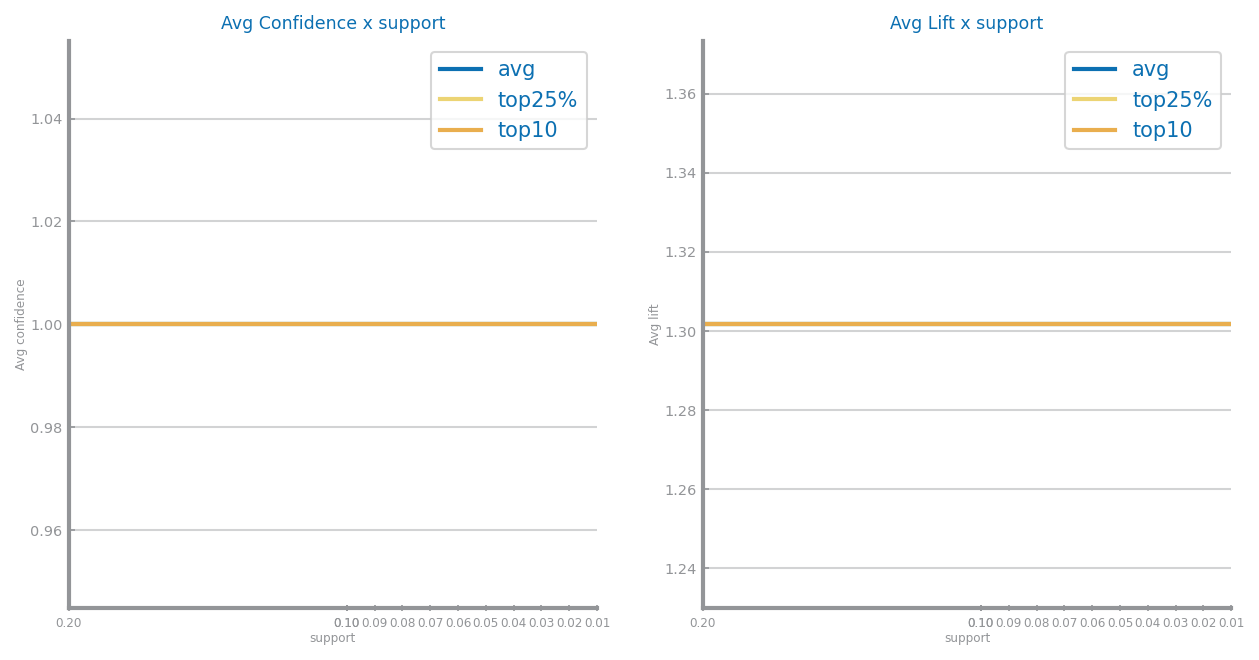

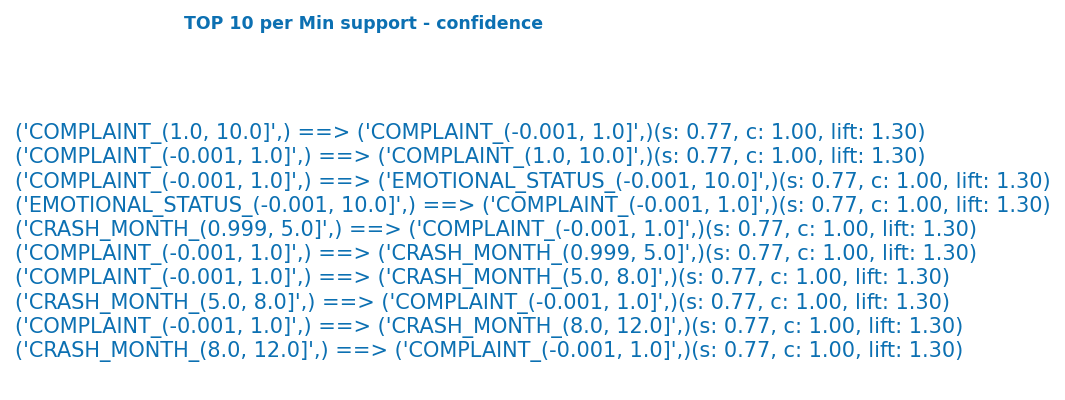

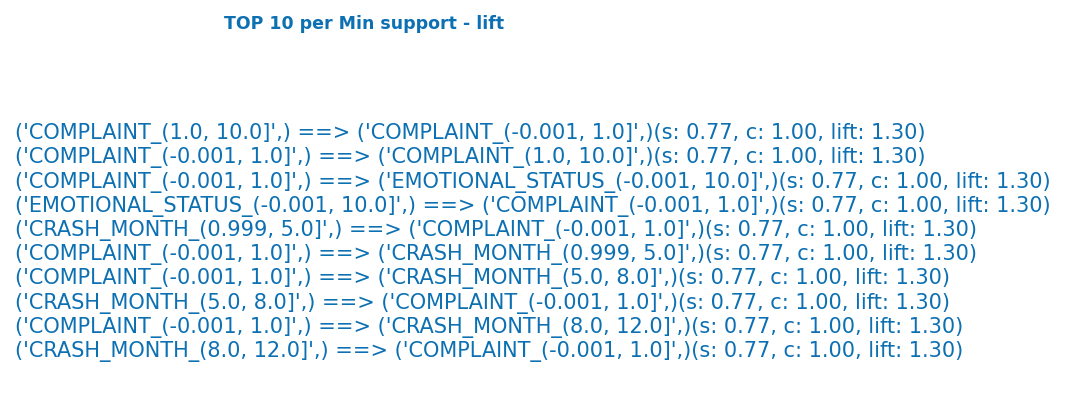

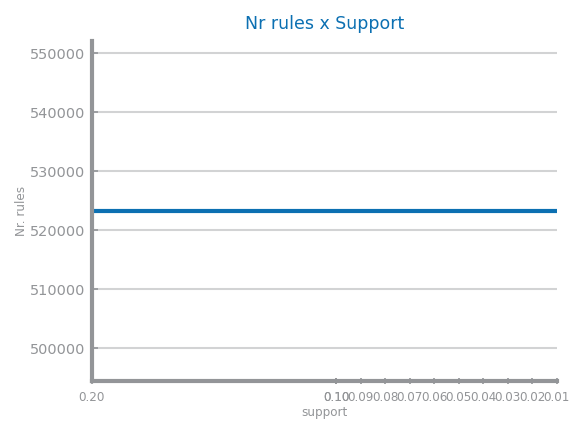

In [ ]:
nr_rules_sp = analyse_per_metric(rules, 'support', var_min_sup, file_tag, data_treatment)
plot_line(var_min_sup, nr_rules_sp, title='Nr rules x Support', xlabel='support', ylabel='Nr. rules', percentage=False)
savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_rules_support.png')

Analyse per confidence...


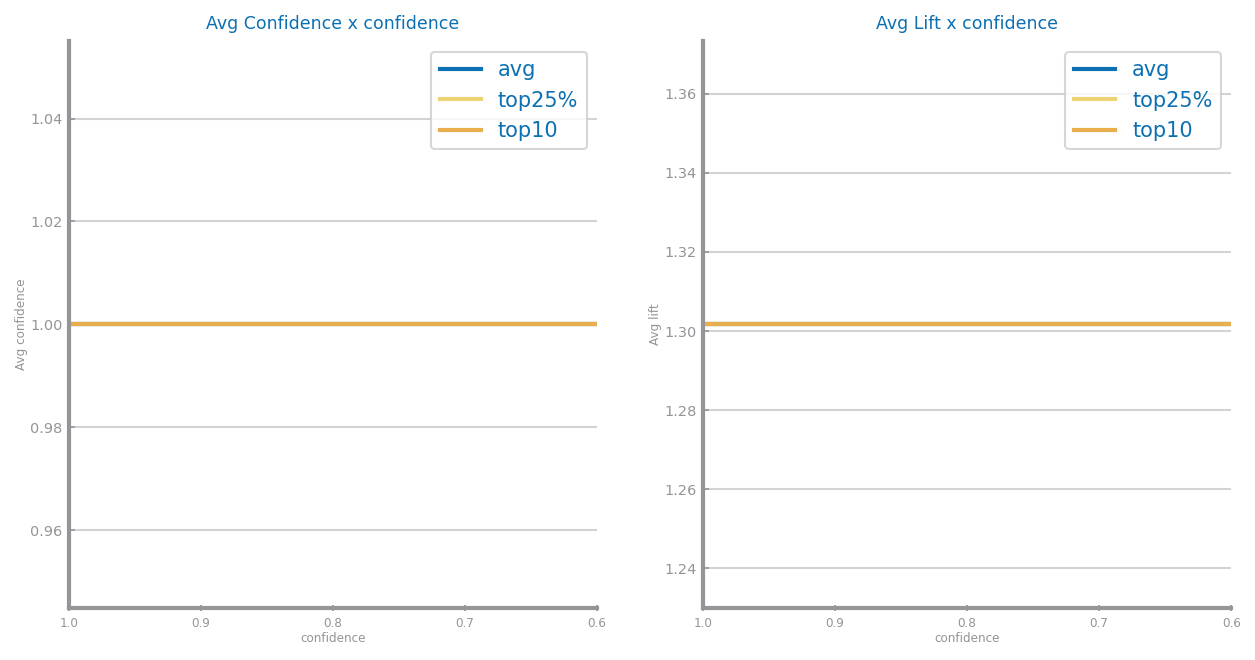

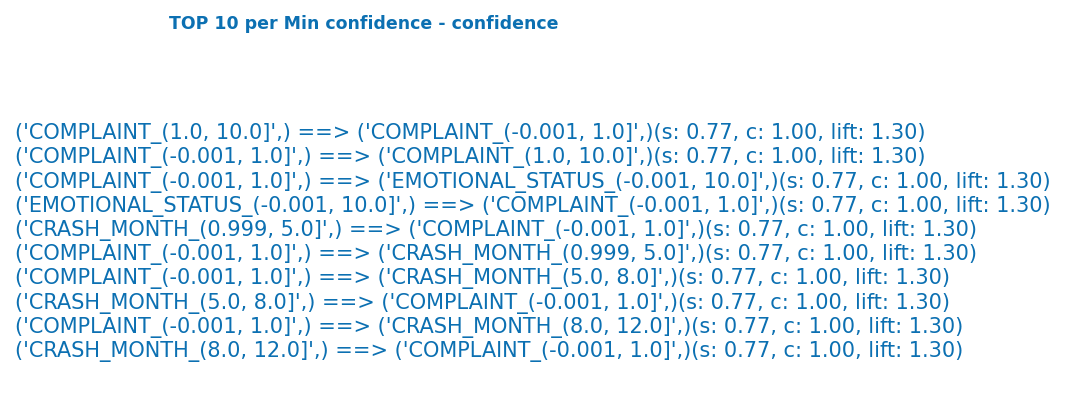

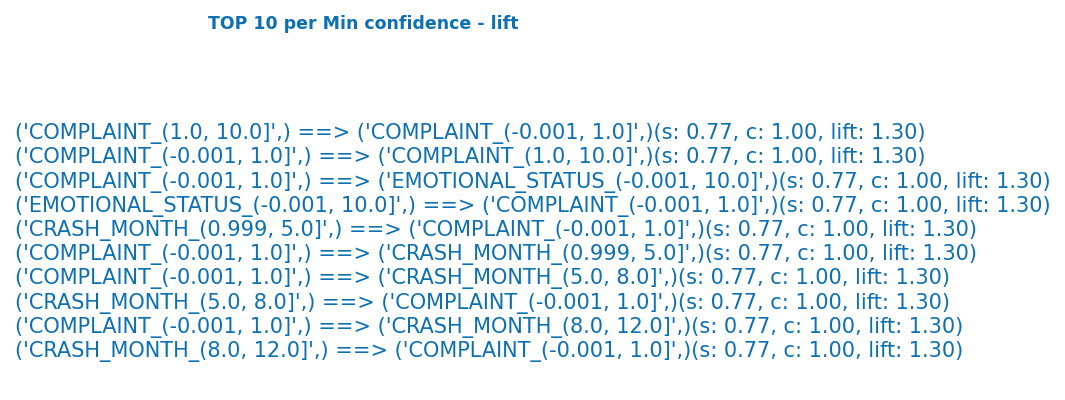

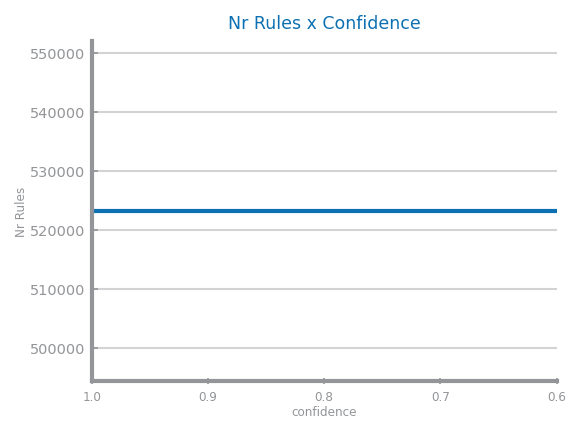

In [ ]:
var_min_conf = [i * MIN_CONF for i in range(10, 5, -1)]
nr_rules_cf = analyse_per_metric(rules, 'confidence', var_min_conf, file_tag, data_treatment)
plot_line(var_min_conf, nr_rules_cf, title='Nr Rules x Confidence', xlabel='confidence', ylabel='Nr Rules', percentage=False)
savefig(f'images/{file_tag}/{file_tag}_{data_treatment}_rules_confidence.png')